In [1]:
import os
import dask
from dask.diagnostics import ProgressBar
import numpy as np
import my_funs 
import xarray as xr
import cProfile
import zarr
import matplotlib.pylab as plt
import geopandas as gpd
import folium
from folium.plugins import MousePosition

# from dask.distributed import Client, progress
# client = Client(processes=False)

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/"


GIMMS analyses, we did not use them since it underestimating LAI also the trend was wiered. We only keep the codes for future references.

In [ ]:
# ds = xr.open_dataset(dir + "data/raw_data/gimms/Original_netcdf/gimms_lai.nc")
# lai = ds["lai"]
# qa = ds["qc"]
# lai = lai.load()
# lai_clean_globe = lai.where(qa==0)
# lai_clean_globe.to_netcdf(out_dir+"gimms/filtered/lai_clean_globe.nc")
# above_shp_file = dir + 'data/shp_files/CoreDomain_geographic.shp'
# geodf = gpd.read_file(above_shp_file)
# lai_clean_above = lai_clean_globe.rio.clip(geodf.geometry) 
# above_shp_file = dir + 'data/shp_files/CoreDomain_geographic.shp'
# geodf = gpd.read_file(above_shp_file)
# lai_clean_above = lai_clean_globe.rio.clip(geodf.geometry) 
# lai_clean_above.to_netcdf(out_dir+"gimms/filtered/lai_clean_above.nc")
# lai_growing = my_funs.growing_season(lai_clean_above)
# lai_growing.to_netcdf(out_dir+"/gimms/resampled/lai_growing_above.nc")

Read LAI data from NOAA CDR

In [3]:
lai = xr.open_dataarray(dir+"data/processed_data/noaa_nc/lai_fapar/resampled/lai_growing.nc")

In [44]:
from sklearn.linear_model import TheilSenRegressor
def _theilsen(y):
    x = np.arange(len(y)).reshape(-1, 1)
    if np.isnan(y).all():
        return
    I = np.where(np.isnan(y))
    if len(I[0]) > 1:
        return np.nan
    yy = np.delete(y, I)
    x = np.arange(len(yy)).reshape(-1, 1)
    reg = TheilSenRegressor(random_state=0).fit(x, yy)
    return reg.coef_

def theilsen(xrd):
    return xr.apply_ufunc(
    _theilsen,
    xrd,
    input_core_dims=[["time"]],
    # dask="allowed",
    # output_dtypes=float,
    vectorize=True,)
    

In [45]:
trend = theilsen(lai[:,100:110,400:410])

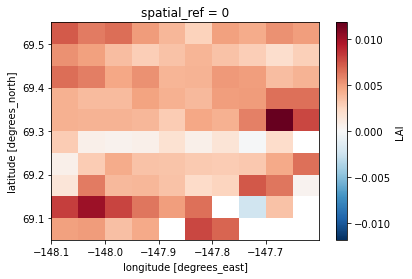

In [47]:
trend.plot()

In [30]:
trend.to_netcdf(out_dir+"noaa_nc/lai_fapar/trend/growing_trend.nc")

In [35]:
trend[100:110,400:410]

<xarray.DataArray 'LAI' (latitude: 10, longitude: 10)>
array([[array([0.00722605]), array([0.00620335]), array([0.00658442]),
        array([0.00507207]), array([0.00397133]), array([0.00270152]),
        array([0.00484739]), array([0.00443601]), array([0.00542705]),
        array([0.00491529])],
       [array([0.00543506]), array([0.00485267]), array([0.00369383]),
        array([0.00291172]), array([0.00351058]), array([0.00405039]),
        array([0.00346315]), array([0.00288169]), array([0.00208572]),
        array([0.00283654])],
       [array([0.00658406]), array([0.00603576]), array([0.00459899]),
        array([0.00537425]), array([0.00399179]), array([0.00413114]),
        array([0.0051701]), array([0.0049443]), array([0.0036503]),
        array([0.00416233])],
       [array([0.00419373]), array([0.00371512]), array([0.00376701]),
        array([0.00480299]), array([0.00423009]), array([0.00384581]),
        array([0.00493357]), array([0.00503848]), array([0.00655315]),
        array([0.00651933])],
       [array([0.00424856]), array([0.00415912]), array([0.00408071]),
        array([0.00397778]), array([0.00302527]), array([0.00461029]),
        array([0.00423464]), array([0.00593859]), array([0.01185418]),
        array([0.00790971])],
       [array([0.00301833]), array([0.00071848]), array([0.00054692]),
        array([0.00070577]), array([0.00176481]), array([0.0006563]),
        array([0.00164068]), array([-0.00015436]), array([0.00221432]),
        None],
       [array([0.00073594]), array([0.00304379]), array([0.00441091]),
        array([0.003488]), array([0.00340622]), array([0.00311445]),
        array([0.00300622]), array([0.00314998]), array([0.00447201]),
        array([0.00655529])],
       [array([0.00148265]), array([0.00612042]), array([0.0038598]),
        array([0.00397672]), array([0.0034546]), array([0.00231322]),
        array([0.00263253]), array([0.00738662]), array([0.00636948]),
        array([0.00038728])],
       [array([0.00823939]), array([0.01013683]), array([0.00796612]),
        array([0.00633206]), array([0.00497406]), array([0.00651572]),
        None, array([-0.00232326]), array([0.00351366]), None],
       [array([0.00487059]), array([0.00505329]), array([0.0035898]),
        array([0.00451813]), None, array([0.00793843]),
        array([0.00688025]), None, None, None]], dtype=object)
Coordinates:
  * latitude     (latitude) float32 69.53 69.47 69.43 ... 69.18 69.12 69.07
  * longitude    (longitude) float32 -148.1 -148.0 -148.0 ... -147.7 -147.6
    spatial_ref  int64 0

In [ ]:
from sklearn.linear_model import TheilSenRegressor
def _theilsen(y,n):
    x = np.arange(len(y)).reshape(-1, 1)
    if np.isnan(y).all():
        return

    I = np.where(np.isnan(y))
    if len(I[0]) > 1:
        return np.nan

    yy = np.delete(y, I)
    x = np.arange(len(yy)).reshape(-1, 1)
    # reg = TheilSenRegressor(random_state=1, n_subsamples=20, max_iter=300,n_jobs=-1).fit(x, yy)
    reg = TheilSenRegressor(random_state=0,n_subsamples=n).fit(x, yy)
    # reg = LinearRegression().fit(x, yy)
    return reg.coef_
    # return reg.estimator_.coef_


In [ ]:
y = lai_growing_mean.values
x = np.arange(len(y)).reshape(-1, 1)
cof = theilsen(y,2)

In [ ]:

plt.scatter(x,y)

In [ ]:
noaa = xr.open_dataarray(out_dir+"noaa_nc/lai_fapar/resampled/lai_growing.nc")

In [ ]:
m = noaa.mean(["latitude","longitude"]).values
x = np.arange(len(m)).reshape(-1, 1)
plt.scatter(x,m)

In [ ]:
ds_lai = xr.open_zarr(dir+'data/raw_data/noaa_cdr/lai_fapar/noaa_lai_fapar_clipped_raw.zarr')
lai = ds_lai["LAI"]
fapar= ds_lai["FAPAR"]
qa_lai = ds_lai["QA"]
ds_ndvi = xr.open_zarr(dir+'data/raw_data/noaa_cdr/ndvi/noaa_ndvi_clipped_raw.zarr')
ndvi = ds_ndvi["NDVI"]
qa_ndvi = ds_ndvi["QA"]

# Apply the quality control
we only apply the quality control to the LAI and the NDVI. Then we will select spectral bands (red, NIR) where we have good NDVI and calculate the EVI. 

In [ ]:
# Convert QAs to binary
qa_lai_binary = my_funs.dec2bin(qa_lai,9)
qa_ndvi_binary = my_funs.dec2bin(qa_ndvi,16)

### Apply mask based on binary QAs aquired from previous step

In [ ]:
qa_lai_binary = qa_lai_binary.astype(str)
qa_lai_mask = my_funs.avhrr_mask(qa_lai_binary,dask="allowed",var="LAI")
# lai_masked = lai.where(qa_mask)
fapar_maked = fapar.where(qa_lai_mask)

qa_ndvi_binary = qa_ndvi_binary.astype(str)
qa_mask_ndvi =my_funs.avhrr_mask(qa_ndvi_binary,dask="allowed",var="NDVI")
ndvi_masked = ndvi.where(qa_mask_ndvi)

In [ ]:
# with ProgressBar():
#     lai_filtered = lai_masked.compute()
# with ProgressBar():
#     ndvi_filtered = ndvi_masked.compute()

# In case staritng the dask distributed client the above progressbar does not work and we should use the following commands
fapar_maked_ds = fapar_maked.to_dataset()
m = client.compute(fapar_maked_ds)

In [ ]:
progress(m)
fapar_maked_ds.to_zarr(out_dir+"data/processed_data/noaa_nc/lai_fapar/filtered/fapar_filtered.zarr")

In [ ]:
ndvi_masked_ds = ndvi_masked.to_dataset()
m2 = client.compute(ndvi_masked_ds)

In [ ]:
progress(m2)
ndvi_masked_ds.to_zarr(out_dir+"data/processed_data/noaa_nc/ndvi/filtered/ndvi_filtered2.zarr")

# Calculate NIRv (Later)

In [ ]:
lai = xr.open_dataarray(dir+"data/processed_data/noaa_nc/lai_fapar/filtered/lai_filtered.nc")
ndvi = xr.open_dataarray(dir+"data/processed_data/noaa_nc/ndvi/filtered/ndvi_filtered.nc")
ds_refl = xr.open_zarr(dir+'data/raw_data/noaa_cdr/reflectance/noaa_reflectance_clipped_raw.zarr')
nir = ds_refl["SREFL_CH2"]
ndvi_good = my_funs.isfinite(ndvi)
nir_good = nir.where(ndvi_good)
nir_good.to_netcdf(dir+"data/processed_data/noaa_nc/reflectance/filtered/NIR_filtered.nc")

# Resample time series data

In [ ]:
# lai = xr.open_dataarray(dir+"/data/processed_data/noaa_nc/lai_fapar/filtered/lai_filtered.nc",chunks=({'latitude': 100, 'longitude': 100}))
lai = xr.open_dataarray(
    dir + "/data/processed_data/noaa_nc/lai_fapar/filtered/lai_filtered.nc"
)

lai_monthly_resample_mean = lai.resample(time="1MS").mean()
lai_monthly_resample_mean.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_monthly_resample_mean.nc"
)
print("lai_monthly_resample_mean Done!")

lai_monthly_resample_max = lai.resample(time="1MS").max()
lai_monthly_resample_max.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_monthly_resample_max.nc"
)
print("lai_monthly_resample_max Done!")

lai_monthly_group_mean = lai.groupby("time.month").mean()
lai_monthly_group_mean.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_monthly_group_mean.nc"
)
print("lai_monthly_group_mean Done!")

lai_monthly_group_max = lai.groupby("time.month").max()
lai_monthly_group_max.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_monthly_group_max.nc"
)
print("lai_monthly_group_max Done!")

lai_seasonal_resample_mean = my_funs.weighted_season_resmaple(lai)
lai_seasonal_resample_mean.to_netcdf(
    dir
    + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_seasonal_resample_mean.nc"
)
print("lai_seasonal_resample_mean Done!")

lai_seaonal_group_mean = my_funs.weighted_season_group(lai)
lai_seaonal_group_mean.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_seaonal_group_mean.nc"
)
print("lai_seaonal_group_mean Done!")

lai_seasonal_resample_max = lai.resample(time="Q-DEC").max()
lai_seasonal_resample_max.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_seasonal_resample_max.nc"
)
print("lai_seasonal_resample_max Done!")

lai_seasonal_group_max = lai.groupby("time.season").max()
lai_seasonal_group_max.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_seasonal_group_max.nc"
)
print("lai_seasonal_group_max Done!")

lai_annualresample_mean = lai.groupby("time.year").mean()
lai_annualresample_mean.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_annualresample_mean.nc"
)
print("lai_annualresample_mean Done!")

lai_annualresample_max = lai.groupby("time.year").max()
lai_annualresample_max.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_annualresample_max.nc"
)
print("lai_annualresample_max Done!")

lai_growing = my_funs.growing_season(lai)
lai_growing.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_growing.nc"
)

print("All done!")


# Trend analyses

In [ ]:
lai_filtered = xr.open_dataarray(out_dir+"data/processed_data/noaa_nc/lai_fapar/filtered/lai_filtered.nc")
lai_growing = growing_season(lai_filtered)
lai_growing.to_netcdf(out_dir+"data/processed_data/noaa_nc/lai_fapar/grouped/lai_growing.nc")

In [ ]:
def xarray_Linear_trend(xarr, var_unit):
    from scipy import stats
    import numpy as np
    # getting shapes

    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa**2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya**2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name = '_slope'
    xarr_slope.attrs['units'] = var_unit
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name = '_Pvalue'
    xarr_p.attrs[
        'info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

In [ ]:
lai_growing = lai_growing.rename({"year":"time"})

In [ ]:
import pandas as pd
a = lai_growing.time.to_pandas().index
b = pd.to_datetime(a, format='%Y')
# lai_growing.time = b
lai_growing["time"] = b
lai_growing_trend = xarray_trend(lai_growing, var_unit="m / m / year")

In [ ]:
plt.figure(figsize=(16,8))
lai_growing_trend["slope"].plot()
plt.savefig(out_dir+"/Figures/LAI_growing_trend.png")

In [ ]:
lai_growing_mean = lai_growing.mean(["latitude","longitude"])
lai_growing_mean